This script solves the 1D heat equation:
$$\frac{\partial u}{\partial t} = \frac{\partial}{\partial x} \left(\alpha(x)\frac{\partial u}{\partial x}\right) $$

with Dirichlet boundary conditions. The numerical scheme is a forward-time centered-space (FTCS) scheme. Note that the stability of the numerical solutions is dependent on the thermal diffusivity, $\alpha(x)$ via the constraint
$$  \alpha \frac{\Delta t}{(\Delta x)^2}  \leq \frac{1}{2}

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# First, define the numerical solution for the heat equation
def heateq_1D(alpha, t_domain, x_domain, IC, BC_0, BC_L):
    Nx = len(x_domain)       # Number of spatial grid points
    Nt = len(t_domain)       # Number of time steps
    dx = x_domain[1] - x_domain[0]  # Spatial step size
    dt = t_domain[1] - t_domain[0]  # Time step size

    if np.isscalar(alpha):
        alpha_x = alpha * np.ones(Nx)
    else:
        alpha_x = alpha

    # Initial condition
    u = IC.copy()

    # Boundary conditions
    u[0] = BC_0  # Left boundary (Dirichlet condition)
    u[-1] = BC_L  # Right boundary (Dirichlet condition)

    u_save = np.zeros((Nt, Nx))
    # Time-stepping loop
    for t_i in range(Nt):
        u_new = u.copy()
        for i in range(1, Nx-1):
            da_dx = 0.5*(alpha_x[i+1]-alpha_x[i-1])/dx
            du_dx = 0.5*(u[i+1]-u[i-1])/dx
            d2u_dx = (u[i+1] - 2*u[i] + u[i-1])/dx**2
            u_new[i] = u[i] + dt*(da_dx*du_dx + alpha_x[i]*d2u_dx)
        u = u_new
        u_save[t_i, :] = u

    return u_save


In [4]:

# Parameters
T = 5  # End time for numerical solution
L = 1  # Length of the 1D element
dx = 0.05  # Spatial discretization
dt = 1e-3  # Temporal discretization
x_domain = np.arange(0, L+dx, dx)  # x points
t_domain = np.arange(0, T+dt, dt)  # t points
Nx = len(x_domain)  # Number of x points
Nt = len(t_domain)  # Number of t points

# Initial and boundary conditions
IC = np.ones(Nx)
BC_0 = 4  # BC at x=0
BC_L = 5  # BC at x=L

# Thermal conductivity parameter
alpha = 0.01  # Thermal diffusivity constant (m^2/s)
# alpha = 0.03*np.abs(np.cos(x_domain*2*np.pi))+0.01  # Thermal diffusivity constant (m^2/s)

# Stability check
stab_number = np.max(alpha) * dt / (dx ** 2)
if stab_number >= 0.5:
    raise Warning('Numerical Instability may occur.')


# Run the 1D heat equation solver
u_save = heateq_1D(alpha, t_domain, x_domain, IC, BC_0, BC_L)


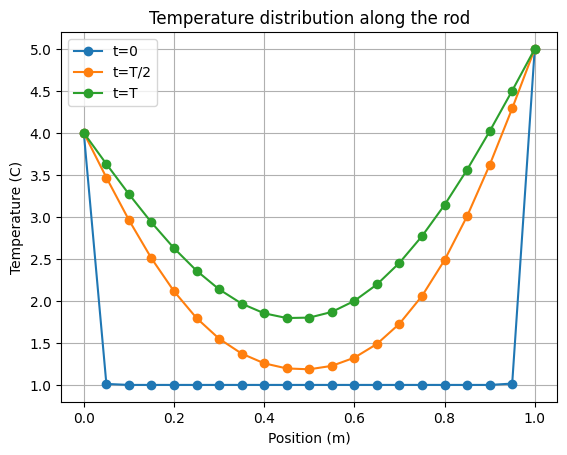

In [5]:

# Plot the final temperature distribution
plt.figure()
plt.plot(x_domain, u_save[0, :], '-o', label='t=0')
plt.plot(x_domain, u_save[len(t_domain)//2, :], '-o', label='t=T/2')
plt.plot(x_domain, u_save[-1, :], '-o', label='t=T')
plt.legend()
plt.xlabel('Position (m)')
plt.ylabel('Temperature (C)')
plt.title('Temperature distribution along the rod')
plt.grid(True)
plt.show()


Original data shape: (5001, 21)
POD data shape: (51, 21)


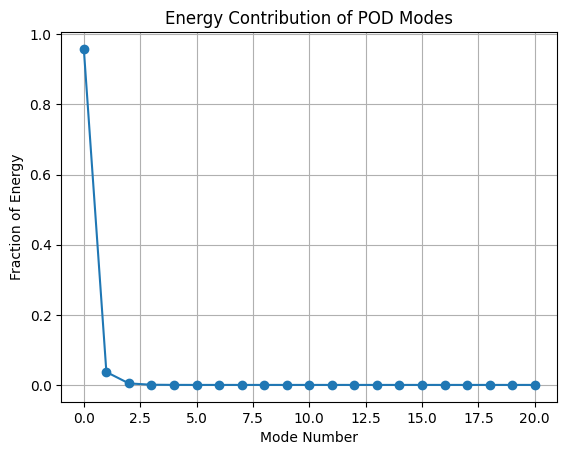

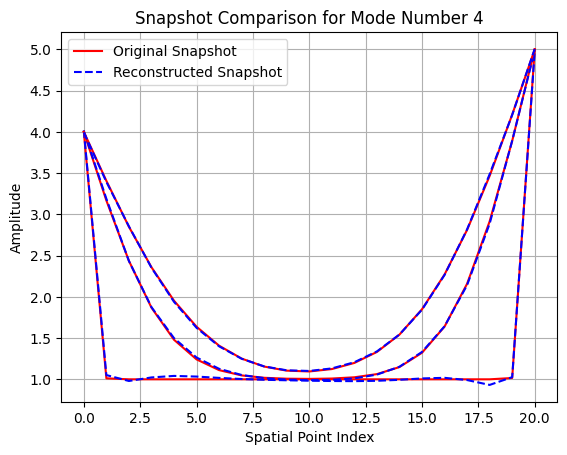

In [6]:
# Now, get snapshots of the solution
U_snap = u_save[::100, :]  # Get every 100th temporal point (transposed equivalent in Python)

# Spatial and temporal sizes
N = U_snap.shape[0]  # Number of spatial points
M = U_snap.shape[1]  # Number of temporal points

# Center the snapshot data
U_mean = np.mean(U_snap, axis=1, keepdims=True)
U_center = U_snap - U_mean

# Perform Singular Value Decomposition (economical mode)
U, S, Vt = np.linalg.svd(U_center, full_matrices=False)
POD_modes = U  # Spatial modes
POD_coeff = np.dot(np.diag(S), Vt)  # Temporal coefficients

# Number of modes to keep
n_modes = 4  # Number of retained POD modes
singular_values = S
POD_acc = np.sum(singular_values[:n_modes]**2) / np.sum(singular_values**2)  # POD accuracy

# Reconstruct the data using the retained modes
u_POD = U_mean + np.dot(POD_modes[:, :n_modes], POD_coeff[:n_modes, :])

# Display dimensions of original and POD data
print("Original data shape:", u_save.shape)
print("POD data shape:", u_POD.shape)

# Energy contribution of each mode
energy_fraction = singular_values**2 / np.sum(singular_values**2)

# Plot the energy contribution of modes
plt.figure()
plt.plot(energy_fraction, 'o-', label='Energy Fraction')
plt.xlabel('Mode Number')
plt.ylabel('Fraction of Energy')
plt.title('Energy Contribution of POD Modes')
plt.grid(True)
plt.show()

# Optional: Plot original vs reconstructed snapshots
snapshot_idx = [0, M // 2, M - 1]  # Indices of snapshots to compare
plt.figure()
for idx in snapshot_idx:
    plt.plot(U_snap[idx, :], 'r', label='Original Snapshot' if idx == snapshot_idx[0] else "")
    plt.plot(u_POD[idx, :], 'b--', label='Reconstructed Snapshot' if idx == snapshot_idx[0] else "")
plt.xlabel('Spatial Point Index')
plt.ylabel('Amplitude')
plt.title(f'Snapshot Comparison for Mode Number {n_modes}')
plt.legend()
plt.grid(True)
plt.show()
